C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


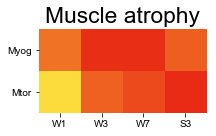

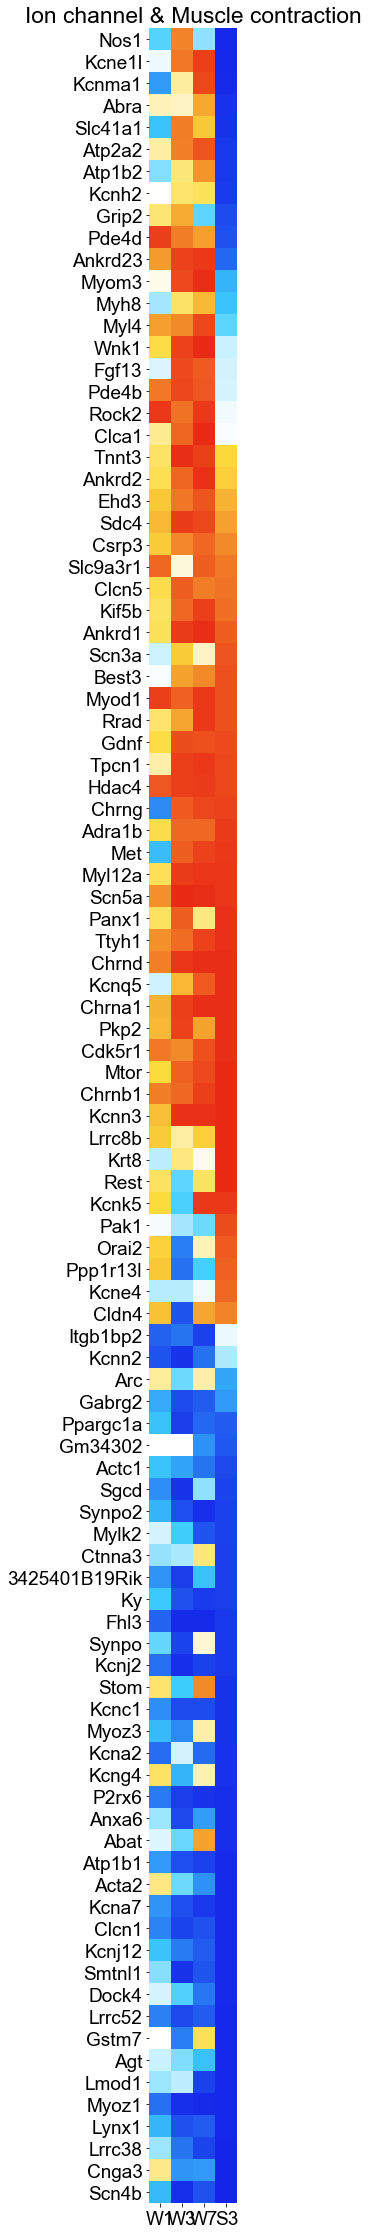

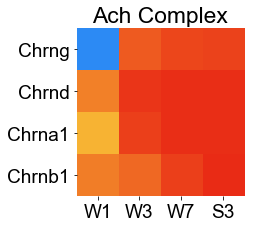

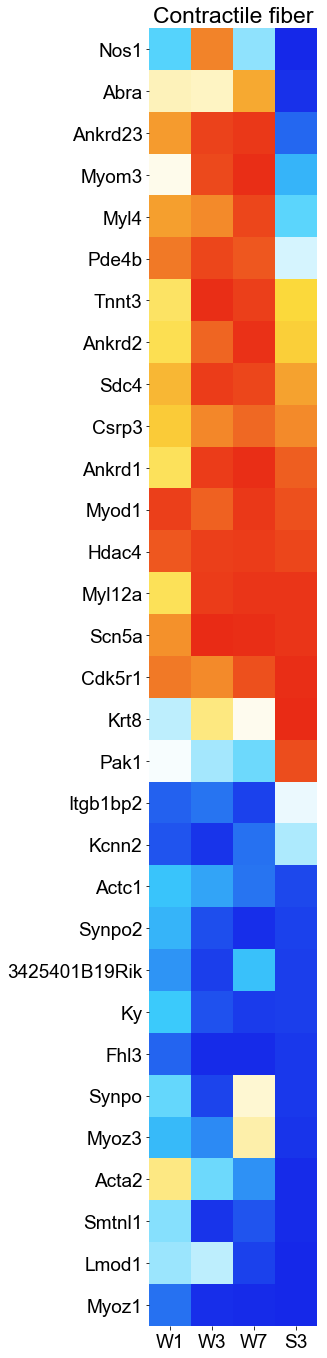

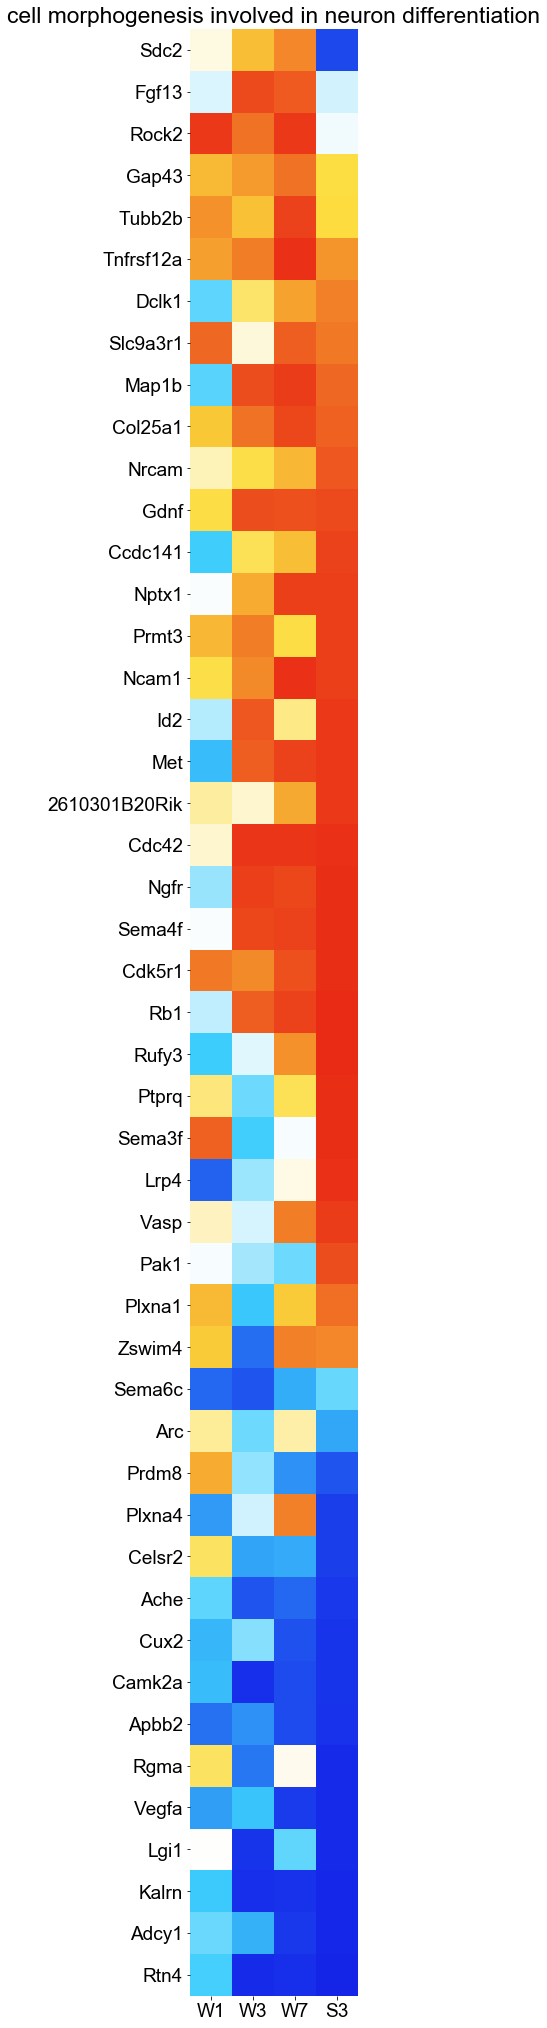

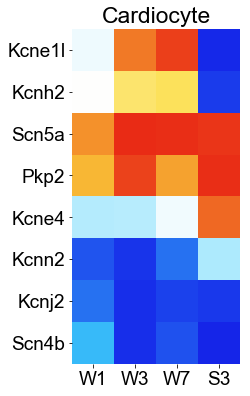

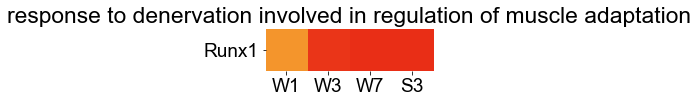

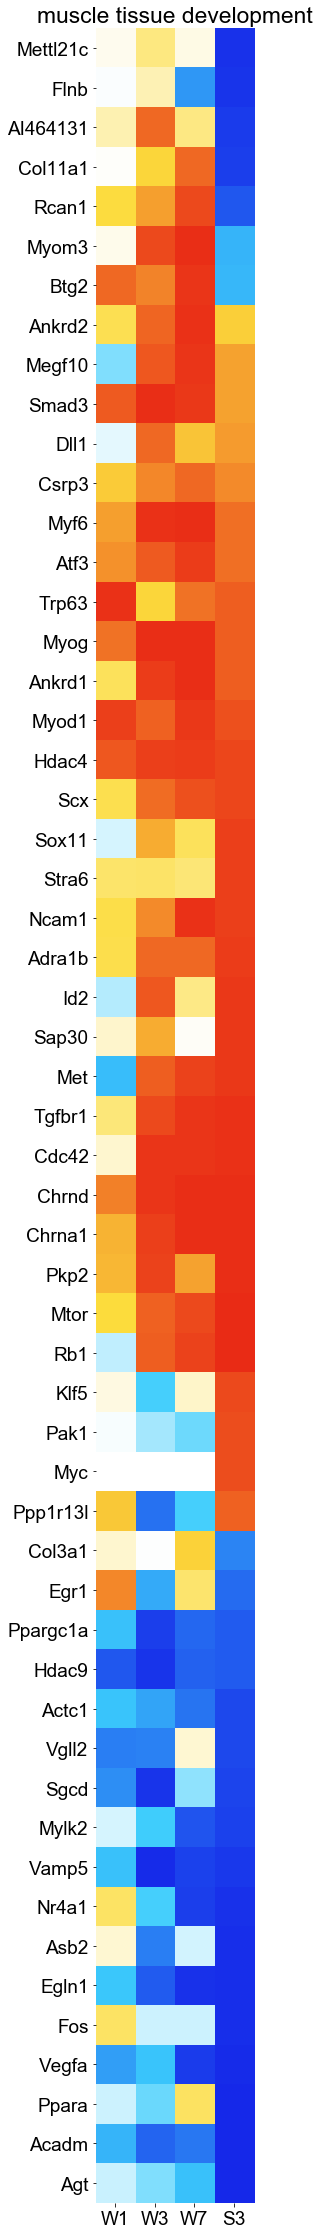

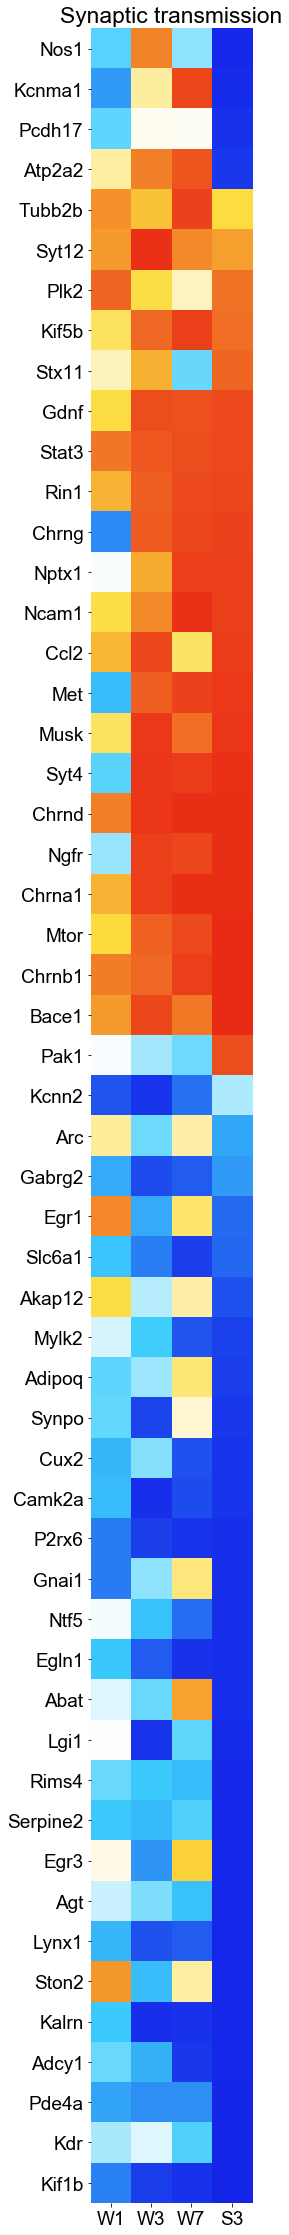

In [2]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
from matplotlib_venn import venn2, venn3

# Load in TPM data 
whisker = pd.read_csv('TPM matrix.csv')
soleus = pd.read_csv('Soleus TPM matrix.csv')

# Load significant transcripts
wsig = pd.read_csv('whisker_sig.csv')
solsig = pd.read_csv('soleus_sig.csv')

# Concatenate significant transcripts from both datasets and then de-duplicate and sort by target_id so we can append
# the q-values onto sig_whisker and sig_soleus so we can sort those by q-value
siglist = wsig.append(solsig)
siglist = siglist.drop_duplicates(subset="Gene name")
siglist = siglist.sort_values("transcript_id").reset_index(drop=True)

# Filter TPM data so only total significant transcripts remain and add q-values
sig_whisker = whisker.loc[whisker["Transcript_ID"].isin(siglist["transcript_id"])].reset_index(drop=True)
sig_soleus = soleus.loc[soleus["Transcript_ID"].isin(siglist["transcript_id"])].reset_index(drop=True)

# Use merge instead?
sig_whisker = pd.merge(sig_whisker, siglist, left_on = "Transcript_ID", right_on = "transcript_id", how = "inner")
sig_soleus = pd.merge(sig_soleus, siglist, left_on = "Transcript_ID", right_on = "transcript_id", how = "inner")

# Re-sorting based off of the q-value
sig_whisker = sig_whisker.sort_values("qval").reset_index(drop=True)
sig_soleus = sig_soleus.sort_values("qval").reset_index(drop=True)
siglist = siglist.sort_values("qval").reset_index(drop=True)

# Saving a checkpoint of the dataframes for sanity check
sig_whisker.to_csv('TestW.csv', encoding='utf-8', index=False)
sig_soleus.to_csv('TestS.csv', encoding='utf-8', index=False)
siglist.to_csv('TestSl.csv', encoding='utf-8', index=False)

#Int location within dataframes, selecting out columns to group for z-scoring
zwhiskd1 = sig_whisker.iloc[:,1:7]
zwhiskd3 = sig_whisker.iloc[:,7:13]
zwhiskd7 = sig_whisker.iloc[:,13:19]
zsol = sig_soleus.iloc[:,1:5]

#Transposed because it's easier to Z-score by column
zwhiskd1 = zwhiskd1.T
zwhiskd3 = zwhiskd3.T
zwhiskd7 = zwhiskd7.T
zsol = zsol.T

#Z-scoring data
zwhiskd1 = zwhiskd1.apply(zscore)
zwhiskd3 = zwhiskd3.apply(zscore)
zwhiskd7 = zwhiskd7.apply(zscore)
zsol = zsol.apply(zscore)

#Remove Z-scores of sham/control samples 
zwhisd1 = pd.concat([zwhiskd1.iloc[1,:], zwhiskd1.iloc[3,:], zwhiskd1.iloc[5,:]], axis = 1, sort = False)
zwhisd3 = pd.concat([zwhiskd3.iloc[1,:], zwhiskd3.iloc[3,:], zwhiskd3.iloc[5,:]], axis = 1, sort = False)
zwhisd7 = pd.concat([zwhiskd7.iloc[1,:], zwhiskd7.iloc[3,:], zwhiskd7.iloc[5,:]], axis = 1, sort = False)
zso = pd.concat([zsol.iloc[1,:],zsol.iloc[3,:]], axis = 1, sort = False)

#Re-Transpose
zwhisd1 = zwhisd1.T
zwhisd3 = zwhisd3.T
zwhisd7 = zwhisd7.T
zso = zso.T

#Average only injured Z-scores
zwhisd1 = zwhisd1.mean(axis=0)
zwhisd3 = zwhisd3.mean(axis=0)
zwhisd7 = zwhisd7.mean(axis=0)
zso = zso.mean(axis=0)

#Concatenate with initial transcript ID's and qvalues and combine into a single dataframe
#Need to add gene names so it's easier to not screw up labeling
zwhiszso = pd.concat([sig_whisker.iloc[:,0], zwhisd1, zwhisd3, zwhisd7, zso, sig_whisker.iloc[:,19:23]], axis = 1, sort = False)

#Make sure Z-score columns are labeled properly
zwhiszso = zwhiszso.rename(index = str, columns = {0:'WD1',1:'WD3',2:'WD7',3:'SD3'})

#Define a simple Z-score binning function
def zbin(x):
    if x >= 0:
        return 1
    elif x < 0:
        return 0

#Apply zbin function element wise on day 3 whisker z-scores and append to the source dataframe    
zwhiszso["Zbin"] = zwhiszso["WD3"].apply(zbin)

#Replace nan Zbin values with 0
zwhiszso['Zbin'] = zwhiszso['Zbin'].fillna(0)

#Sort dataframes first by Zbin descending and then by qval ascending 
zwhiszso = zwhiszso.sort_values(['Zbin','SD3'],ascending=[False, True]).reset_index(drop=True)

#Now re-sort only the 0 Zbin qval's as descending to create a mirrored list of qvals
zwhiszso.loc[zwhiszso['Zbin'] == 0] = zwhiszso.loc[zwhiszso['Zbin'] == 0].sort_values('SD3',ascending=False).values

#First we load in our target groups
targets = pd.read_csv("targets.csv")

#Get group names
col_titles = targets.columns.values

for colum in col_titles:   
    
    # Extract gene list from appropriate column without including Nan fillers due to unequal columns sizes
    genelist = targets[colum].loc[targets[colum].notnull()].values

    #Use the transcript list to select out corresponding z-score rows
    ZW = zwhiszso.loc[zwhiszso["Gene name"].isin(genelist)]

    #Isolate data into numpy matrix
    Z = ZW.iloc[:,1:5].values

    #Create y-labels
    ylabels = ZW["Gene name"].values

    
    ##Plot Data
    
    # Declare parameters
    color = ['#0d02e5','#3ccdfc','#ffffff','#fcdc3c','#e5020d']
    fig, ax = plt.subplots()
    plt.rcParams['font.family'] = "Arial"
    plt.rcParams.update({'font.size': 19})
    plt.rcParams['savefig.bbox'] = 'tight'

    # Create the colormap
    cm = colors.LinearSegmentedColormap.from_list('my_list', color, N=256)

    #Define bounds to colormap
    bounds = np.arange(-1.1,1.1,0.001)
    norm = colors.BoundaryNorm(bounds,cm.N)

    # Apply colormap to data
    im = ax.imshow(Z, origin='upper', cmap=cm, interpolation = "nearest", norm=norm, aspect='equal')
    #cb = fig.colorbar(im, ax=ax, cmap=cm, norm=norm, boundaries=bounds, orientation="horizontal")
    #cb.set_ticks([-1,-0.5,0,0.5,1],update_ticks=True)
    ax.set_yticks(np.arange(0, len(Z), 1))
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(("W1","W3","W7","S3"))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(ylabels)
    ax.set_title(colum)
    fig.set_size_inches(3,40)
